In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import open3d
from mpl_toolkits import mplot3d


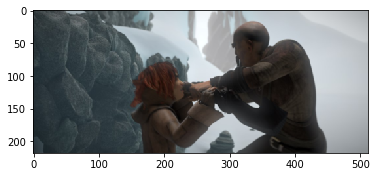

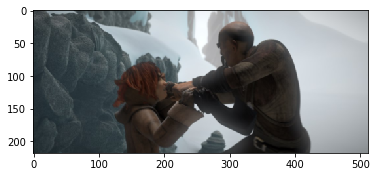

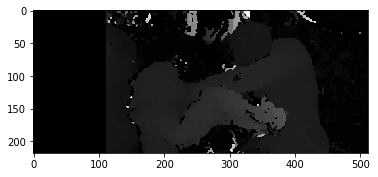

In [2]:
#imgL = cv2.imread('images/flowers-left.png',0)
#imgR = cv2.imread('images/flowers-right.png',0)

imgL = cv2.cvtColor(cv2.imread('ambush_5_left.jpg'),cv2.COLOR_BGR2RGB)
imgR = cv2.cvtColor(cv2.imread('ambush_5_right.jpg'),cv2.COLOR_BGR2RGB)
imgL = cv2.pyrDown(imgL)
imgR = cv2.pyrDown(imgR)
plt.imshow(imgL,'gray'); plt.show()
plt.imshow(imgR,'gray'); plt.show()
win_size = 1
min_disp = 16
max_disp = min_disp * 7
num_disp = max_disp - min_disp
stereo = cv2.StereoSGBM_create(minDisparity = min_disp,numDisparities = num_disp,uniquenessRatio = 10,speckleWindowSize = 100,speckleRange = 64,disp12MaxDiff = 1,P1 = 8*3*win_size**2,P2 = 32*3*win_size**2)
stereo.setSpeckleWindowSize(100)
disparity_map = stereo.compute(imgL,imgR).astype(np.float32) / 16.0

plt.imshow(disparity_map,'gray');
plt.imsave('disparity.jpg',disparity_map,cmap='gray')
plt.show()


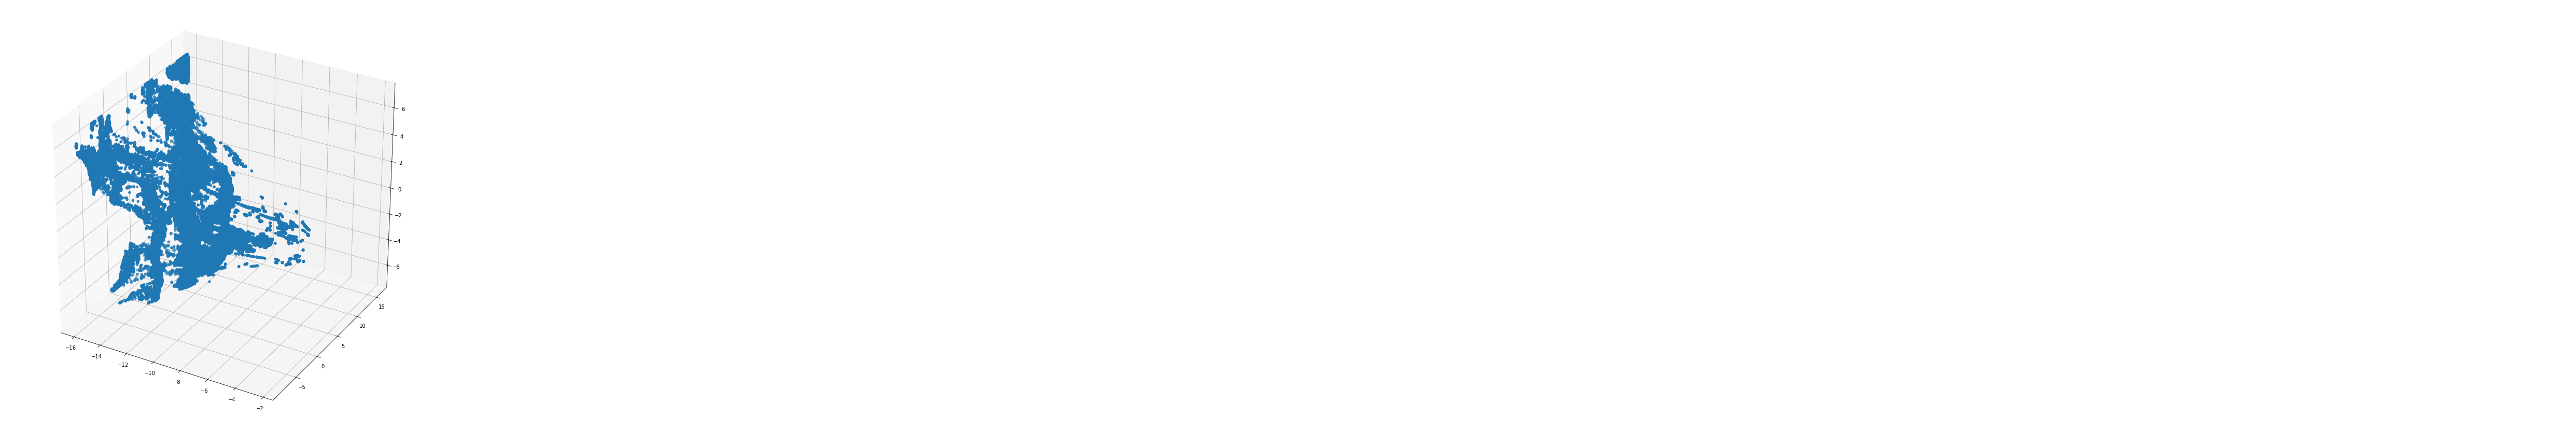

In [3]:
h, w = imgL.shape[:2]
focal_length = 0.5*w
Q = np.float32([[1, 0, 0, -w/2.0],
[0,-1, 0, h/2.0],
# Perspective transformation matrix
[0, 0, 0, -focal_length],
[0, 0, 1, 0]])
pts3D = cv2.reprojectImageTo3D(disparity_map, Q)
mask_map = disparity_map > disparity_map.min()
output_points = pts3D[mask_map]
output_colors = imgL[mask_map]
#plt.figure(figsize=(20,20))
ax = plt.axes(projection='3d')
ax.figure.set_size_inches(15, 15)
ax.figure.savefig('disparityplot.jpg')
ax.scatter3D(output_points[:,2],output_points[:,0],output_points[:,1])

In [4]:
def create_output(vertices, colors, filename):
    colors = colors.reshape(-1, 3)
    vertices = np.hstack([vertices.reshape(-1,3), colors])
    ply_header = '''ply
        format ascii 1.0
        element vertex %(vert_num)d
        property float x
        property float y
        property float z
        property uchar red
        property uchar green
        property uchar blue
        end_header
        '''
    with open(filename, 'w') as f:
        f.write(ply_header % dict(vert_num=len(vertices)))
        np.savetxt(f, vertices, '%f %f %f %d %d %d')

create_output(output_points,output_colors,'final.ply')


In [5]:
#PointCloud = open3d.PointCloud()
#PointCloud.points = open3d.Vector3dVector(output_points.reshape(-1,3))
#PointCloud.colors = open3d.Vector3dVector(output_colors.reshape(-1,3))
#open3d.write_point_cloud("test.ply", PointCloud)
pcd_load = open3d.read_point_cloud("final.ply")
open3d.draw_geometries([pcd_load])
#print(np.asarray(PointCloud.colors))


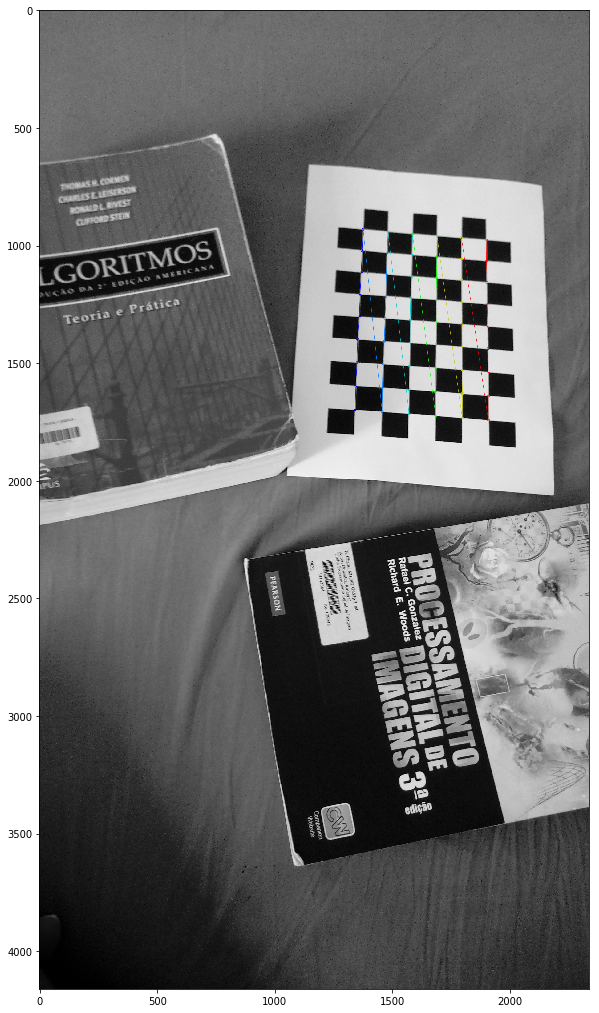

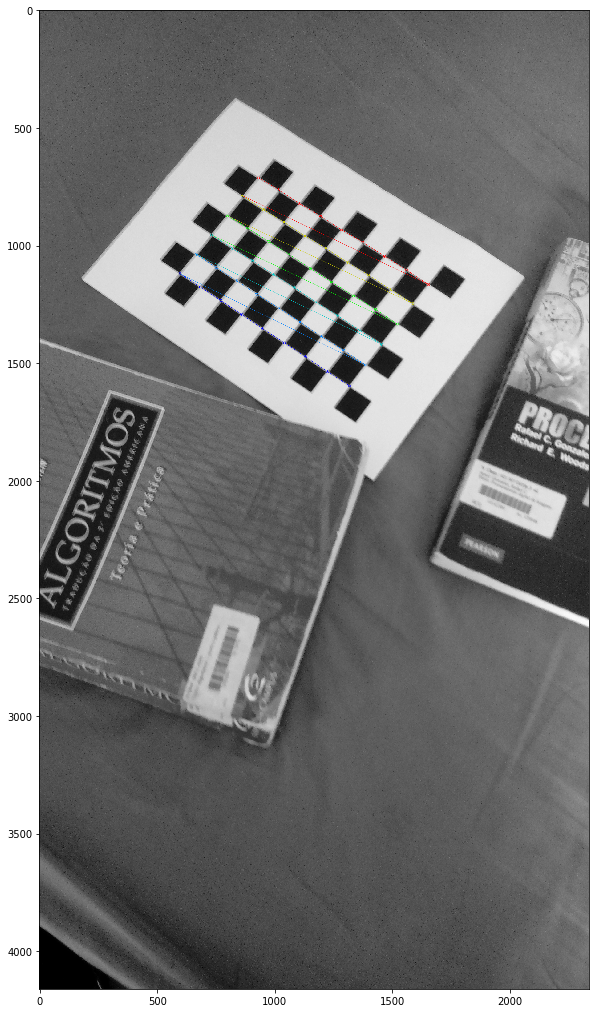

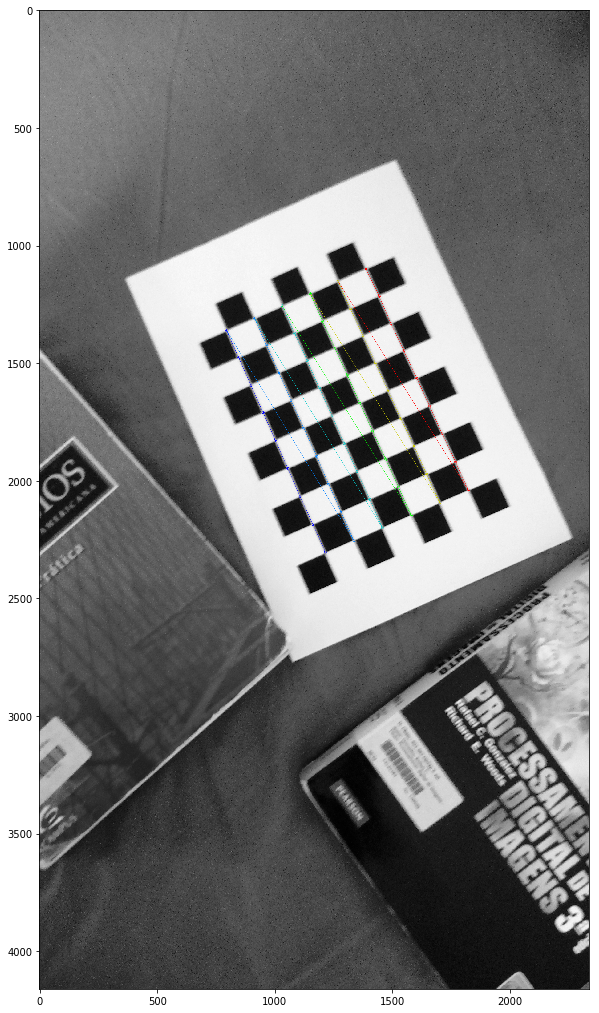

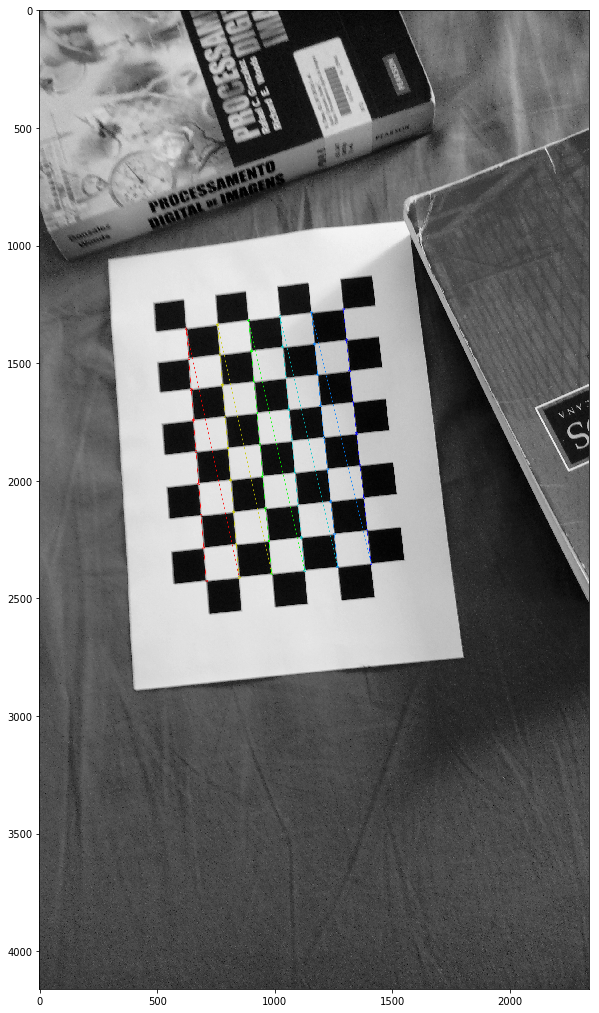

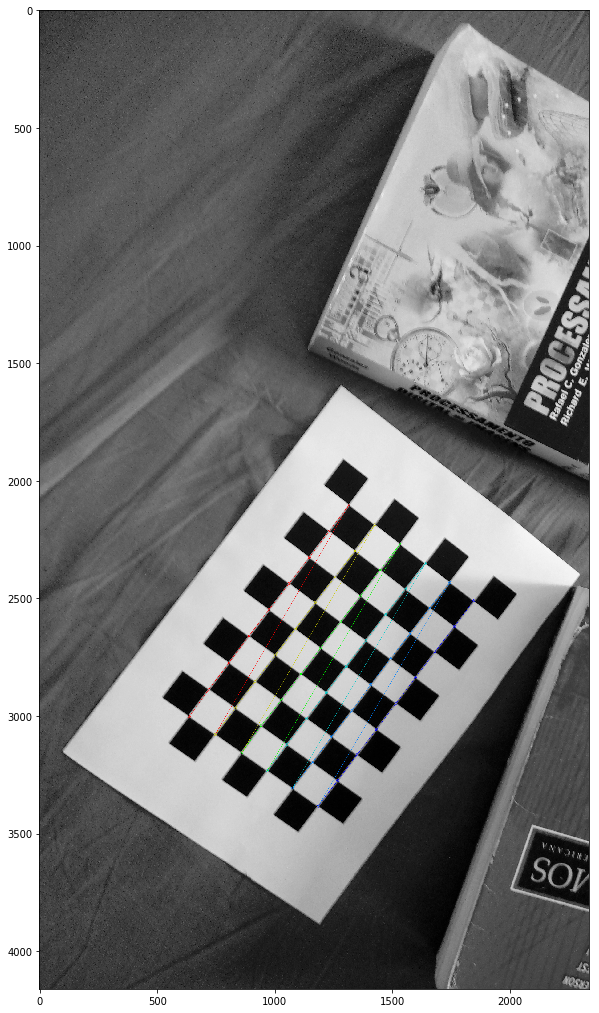

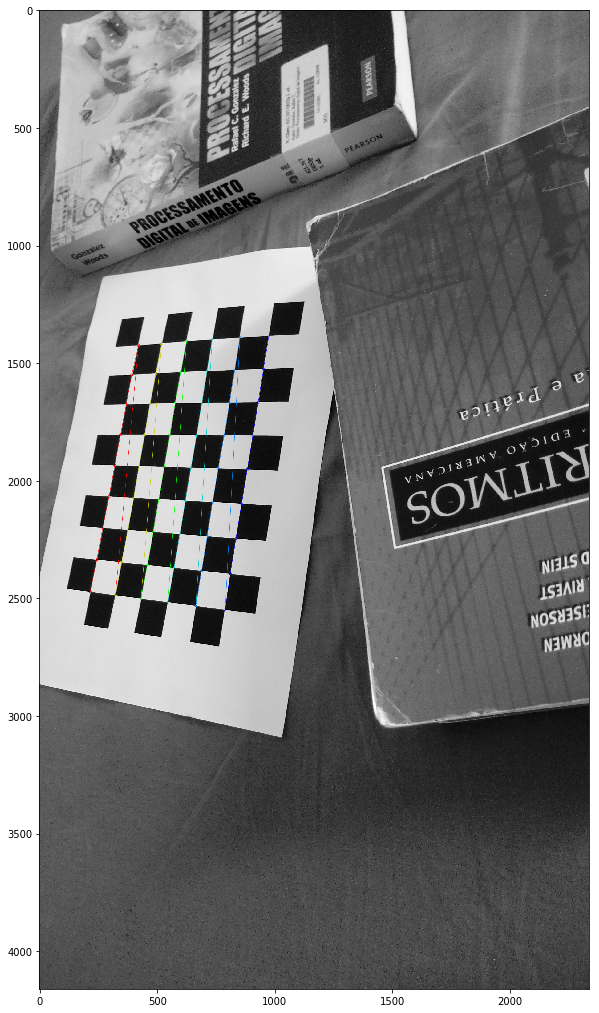

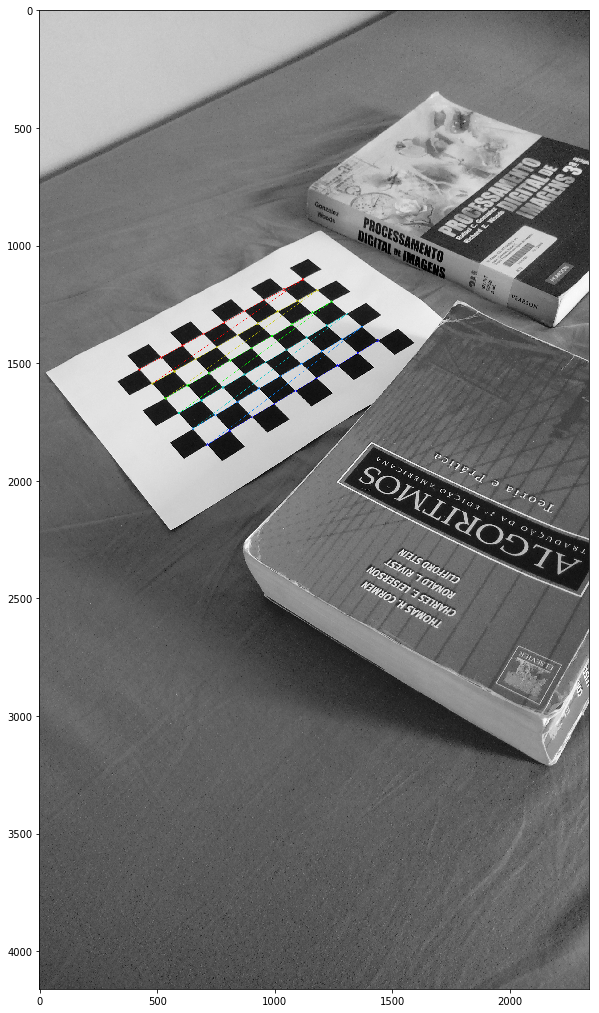

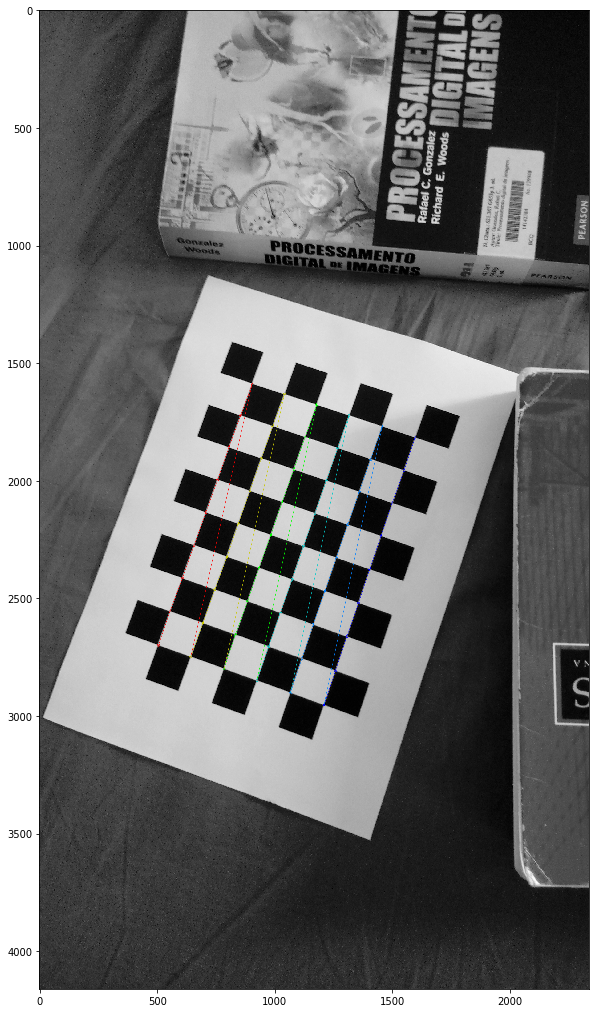

In [6]:
import glob

objp = np.zeros((6*9,3),np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
objp *= 2.1

objpoint = []
imgpoint = []
for im in sorted(glob.glob('calibrate/gray/*.jpg')):
    frame = cv2.imread(im)
    frame1 = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(frame1,(9,6),None)
    if ret == True:
        objpoint.append(objp)
        imgpoint.append(corners)
        frame = cv2.drawChessboardCorners(frame,(9,6),corners,ret)
        plt.figure(figsize=(20,18))
        plt.imshow(frame,'gray')
        plt.show()


In [7]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoint, imgpoint, frame1.shape[::-1],None,None)


In [8]:
img1 = cv2.cvtColor(cv2.imread('desk/3recort.jpg',0),cv2.COLOR_GRAY2RGB)
img2 = cv2.cvtColor(cv2.imread('desk/4recort.jpg',0),cv2.COLOR_GRAY2RGB)

In [9]:
FFD = cv2.FastFeatureDetector_create()
key_points1 = FFD.detect(img1,None)
key_points2 = FFD.detect(img2,None)

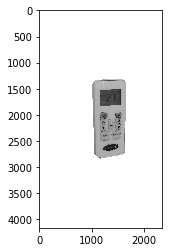

In [10]:
plt.imshow(img1);

In [11]:
list_point1 = [i.pt for i in key_points1]
list_point2 = [i.pt for i in key_points2]


points1 = np.array(list_point1).astype(np.int16)
points2 = np.array(list_point2).astype(np.int16)
#for i,j in zip(key_points1,key_points2):
 #   list_point1.append([int(i.pt[0]),int(i.pt[1])])
  #  lis_point2.append([int(j.pt[0]),int(j.pt[1])])
    #print(tuple(int(i.pt[0]),inta(i.pt[1])))

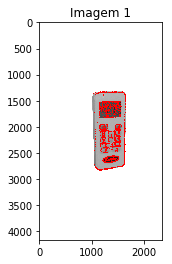

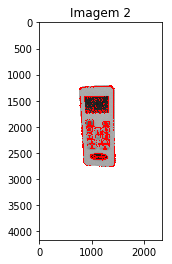

In [12]:
img1_ = img1.copy()
img2_ = img2.copy()
for x in points1:
    cv2.circle(img1_,tuple(x), 7, (255,0,0), -1)
for x2 in points2:
    cv2.circle(img2_,tuple(x2), 7, (255,0,0), -1)
plt.imshow(img1_);
plt.imsave('control1.jpg',img1_)
plt.title("Imagem 1")
plt.show();
plt.title("Imagem 2")
plt.imsave('control2.jpg',img2_)
plt.imshow(img2_);

In [13]:
points_pred_img2, status, error = cv2.calcOpticalFlowPyrLK(img1,img2,np.float32(points1),None)

In [14]:
condition = (status == 1)*(error < 15.)

/home/johnny/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


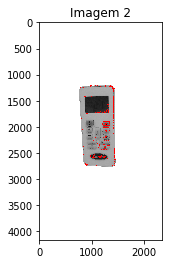

In [15]:
img2_ = img2.copy()
for x2,conditio in zip(points_pred_img2,condition):
    if conditio == True:
        cv2.circle(img2_,tuple(x2), 7, (255,0,0), -1)
plt.title("Imagem 2")
plt.imshow(img2_);

In [16]:
points2_correct = np.int16(points_pred_img2[condition.reshape((condition.shape[0],)) == True,:])
points1_correct = points1[condition.reshape((condition.shape[0],)) == True,:]

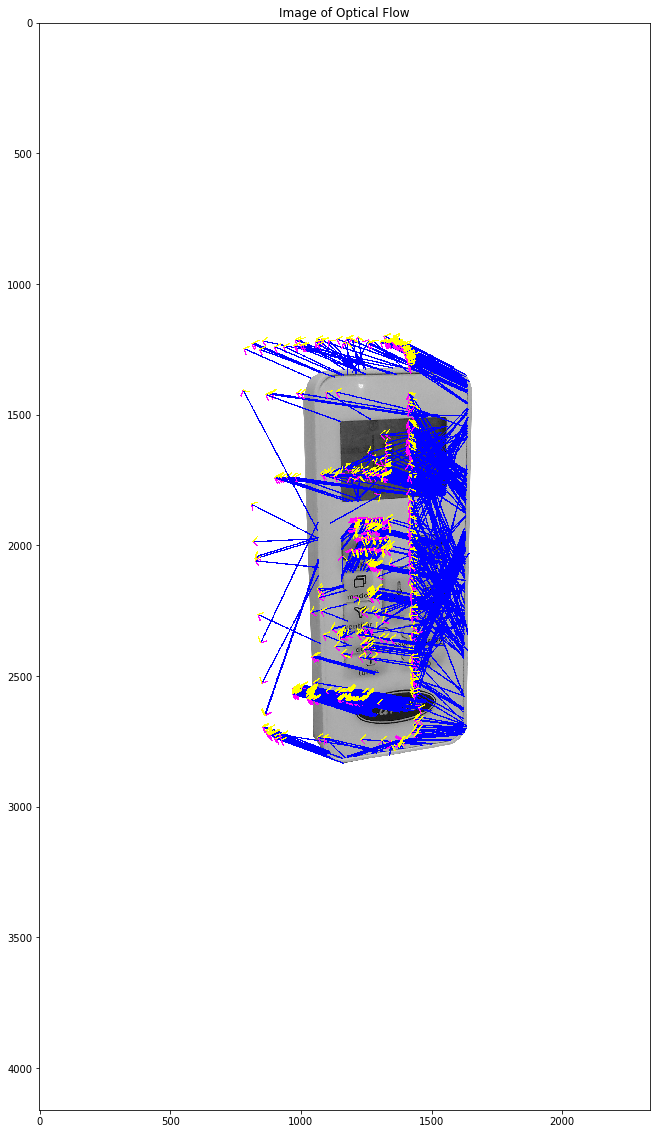

In [17]:
img1_ = img1.copy()

for pos in range(len(points1_correct)):
    cv2.line(img1_, tuple(points1_correct[pos]), tuple(points2_correct[pos]),(0,0,255),3)
     
    theta = np.arctan2(points2_correct[pos][1] -
            points1_correct[pos][1], points2_correct[pos][0] -
            points1_correct[pos][0])
    cv2.line(img1_, tuple(points2_correct[pos]),
            (np.int(points2_correct[pos][0] -
            25*np.cos(theta+np.pi/4)),
            np.int(points2_correct[pos][1] -
            25*np.sin(theta+np.pi/4))), color=(255, 0, 255),thickness=3)
    cv2.line(img1_, tuple(points2_correct[pos]),
            (np.int(points2_correct[pos][0] -
            25*np.cos(theta-np.pi/4)),
            np.int(points2_correct[pos][1] -
            25*np.sin(theta-np.pi/4))), color=(255, 255, 0),thickness=3)
plt.figure(figsize=(30,20))
plt.imshow(img1_)
plt.title("Image of Optical Flow")
plt.imsave('flow.jpg',img1_)
plt.show();

In [18]:
E, mask = cv2.findEssentialMat(points1_correct,points2_correct,focal=1.0, pp=(0., 0.), method=cv2.RANSAC,  threshold=3.0)
ptsL = points1_correct[mask.ravel()==1] # Remove pontos não escolhidos pelo RANSAC. Com apenas 8 todos são escolhidos.
ptsR = points2_correct[mask.ravel()==1]
E

array([[-1.19839647e-04,  4.14960603e-04, -2.90122126e-01],
       [-3.84214873e-04, -1.18422384e-05,  6.44848066e-01],
       [ 4.11096046e-01, -5.75325847e-01,  2.78074414e-05]])

In [19]:
U,V,vt = np.linalg.svd(E)
W = np.array([0.0, -1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,1.0]).reshape(3, 3)


R = U.dot(W).dot(vt)
T = U[:,2]
K = mtx
K_inv = np.linalg.inv(mtx)

first_inliers = []
second_inliers = []
for i in range(len(mask)):
    if mask[i]:
        # normalize and homogenize the image coordinates
        first_inliers.append(K_inv.dot([points1_correct[i][0], points1_correct[i][1], 1.0]))
        second_inliers.append(K_inv.dot([points2_correct[i][0], points2_correct[i][1], 1.0]))
        


Rt1 = np.hstack((np.eye(3), np.zeros((3, 1))))
Rt2 = np.hstack((R, T.reshape(3, 1)))




#------
#R = U.dot(Vt)
#T= U[:,2]
#R1,R2,P1,P2,Q,flags,alpha = cv2.stereoRectify(mtx, dist, mtx, dist,img1.shape[:2],R1,t1,None)

In [20]:
#points4D = cv2.triangulatePoints(P1,P2,np.float32(ptsL.T),np.float32(ptsR.T)).T

points4D = cv2.triangulatePoints(Rt1,Rt2,np.float32(points1_correct.T),np.float32(points2_correct.T)).T
#points4D = cv2.triangulatePoints(P1,P2,np.float32(points1.T),np.float32((points1*E).T)).T

In [21]:
pts3D = points4D[:, :3]/np.repeat(points4D[:, 3], 3).reshape(-1, 3)

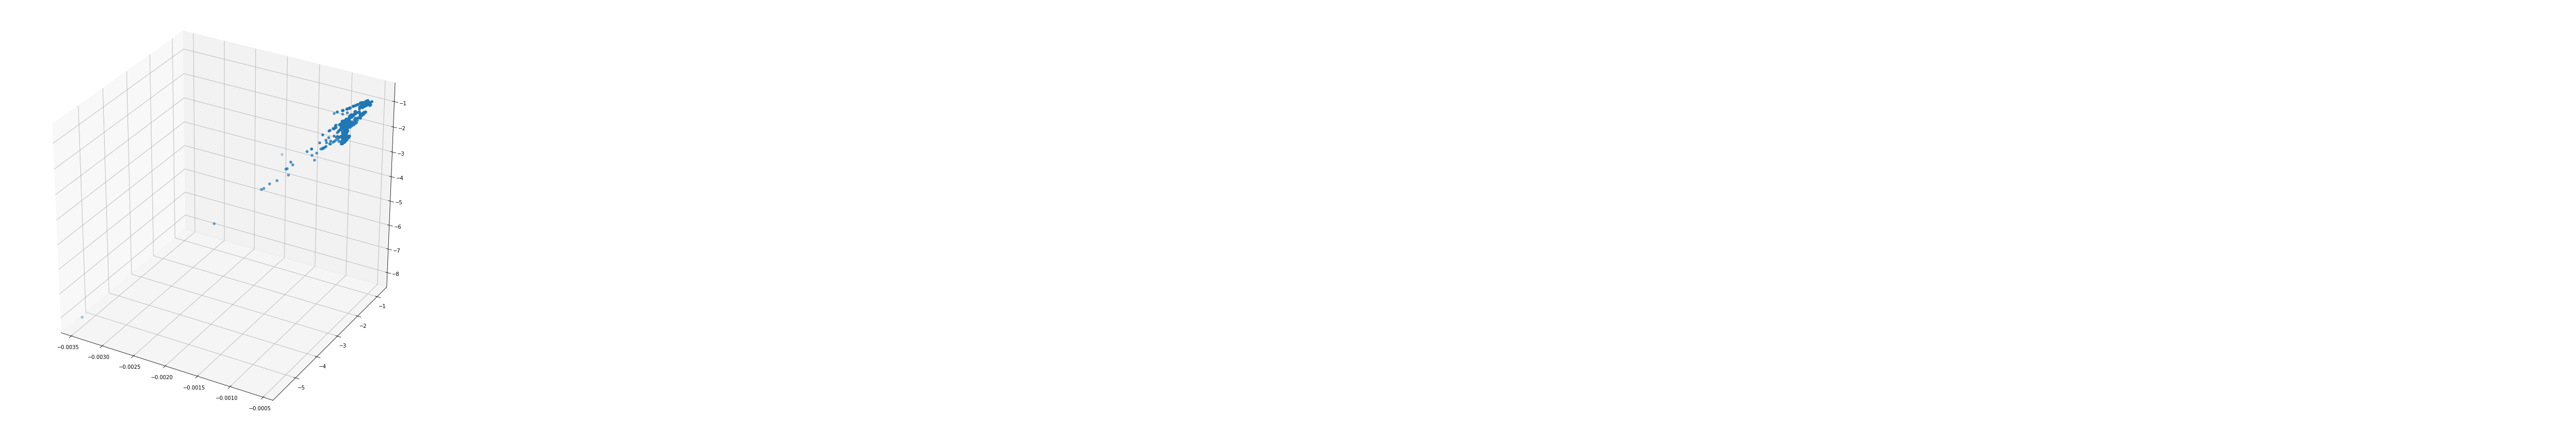

In [22]:
#plt.figure(figsize=(20,20))
ax = plt.axes(projection='3d')
ax.figure.set_size_inches(15, 15)
ax.scatter3D(pts3D[:,2],pts3D[:,0],pts3D[:,1]);

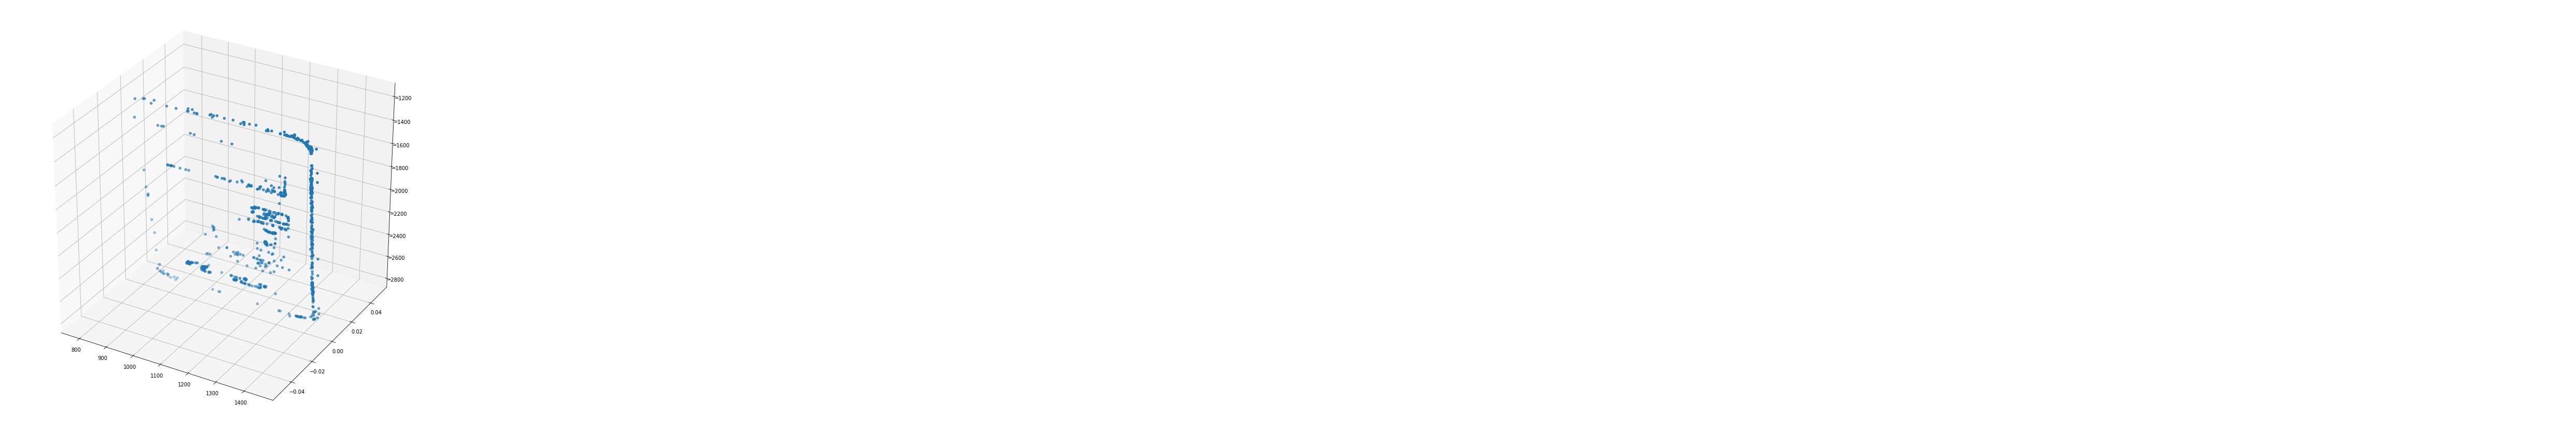

In [23]:
#plt.figure(figsize=(20,20))
ax = plt.axes(projection='3d')
ax.figure.set_size_inches(15, 15)
ax.scatter3D(points2_correct[:,0],0,-points2_correct[:,1]);

In [24]:
PointCloud = open3d.PointCloud()
PointCloud.points = open3d.Vector3dVector(pts3D)
#PointCloud.colors = open3d.Vector3dVector(color)
open3d.write_point_cloud("test.ply", PointCloud)
pcd_load = open3d.read_point_cloud("test.ply")
open3d.draw_geometries([pcd_load])
